In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

In [35]:
url = "https://upload.wikimedia.org/wikipedia/commons/e/e2/Memories_of_Augsburg_V_%283347226605%29.jpg"

901120/895653 [==============================] - 0s 0us/step


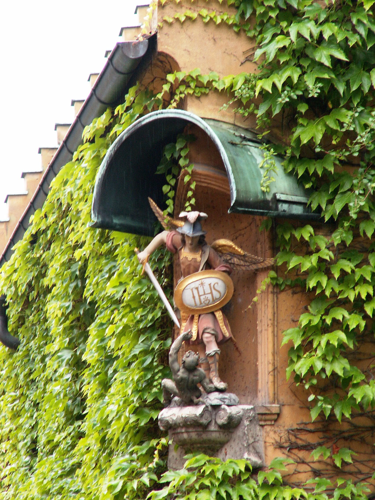

In [36]:
#download image and return in NP ARRAY
def download(url, max_dim = None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

#Normalize image
def deprocess(img):
    img = 255*(img+1.0)/2.0
    return tf.cast(img, tf.uint8)

#show image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))
    
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc by: someone on the internet'))


In [37]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights= 'imagenet')

In [50]:
# Maximize the activations of these layers
names = ['mixed0', 'mixed1']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [45]:
#calculating the loss
def calc_loss(img, model):
    #image forward to get the activations
    #converts image to bactch size one
    img_batch = tf.expand_dims (img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
        
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
        
    return tf.reduce_sum(losses)

In [46]:
#Gradient ascent

class DeepDream(tf.Module):
    
    def __init__(self, model):
        self.model = model
        
    @tf.function(
        input_signature= (
            tf.TensorSpec(shape= [None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape = [], dtype=tf.int32),
            tf.TensorSpec(shape = [], dtype=tf.float32),)
    )
    
    def __call__(self, img, steps, step_size):
        print('Tracing')
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
            
            #calculate gradient of loss with respect to the pixels of the img
            gradients = tape.gradient(loss, img)
            
            #normalize gradients
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            
            #Gradient ASCENT: the loss is maximized so that the image input exicted layers
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)
            
        return loss, img

In [47]:
deepdream = DeepDream(dream_model)

In [48]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)

  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
    
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

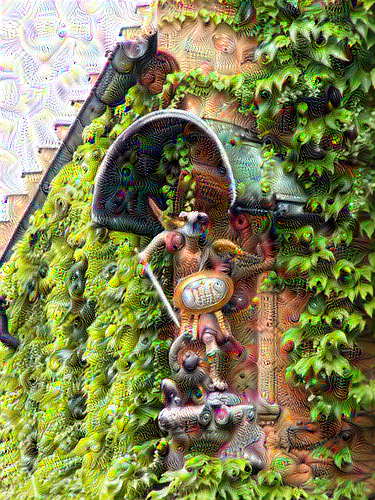

In [51]:
dream_img = run_deep_dream_simple(img = original_img, 
                                 steps=100, step_size=0.01)

In [52]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled